In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
## Model params
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
print(device)
n_embd=384 #size of embedding dimension
batch_size= 32
block_size=256
lr=3e-4
n_head=6
eval_iters=10000

cuda:0


In [3]:
with open('input.txt',mode='r') as f:
    text=f.read()

In [4]:
len(text)

1115393

In [5]:
chars=sorted(list(set([x for x in text])))
vocab_size=len(chars)
print(' '.join(chars))
print(vocab_size)


   ! $ & ' , - . 3 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z
65


In [6]:
## Creating encoder and decoder functions simple value to int maps
## stoi maps char to int
## itos maps int to char
stoi={ch:i for i,ch in enumerate(chars)}
itoi={y:x for x,y in stoi.items()}
def encode(s):
    return [stoi[x] for x in s] #string to tokens
def decode(tok):
    return ''.join([itoi[x] for x in tok])#tokens to string

In [7]:
data=torch.tensor(encode(text),dtype=torch.long)
print(data.shape,data.dtype)
print(data[:100])

torch.Size([1115393]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [8]:
n=int(0.9*data.shape[0])
train_data=data[:n]
val_data=data[n:]

In [9]:
torch.manual_seed(1337)
def get_batch(split:str):
    data=train_data if split=='train' else val_data
    ix=torch.randint(low=0,high=len(data)-block_size-1,size=(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix] )
    y=torch.stack([data[i+1:i+1+block_size] for i in ix] )
    return x,y

In [10]:
class FeedForward(nn.Module):
    def __init__(self,n_embd):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(n_embd,4*n_embd)
                               ,nn.ReLU()
                               ,nn.Linear(4*n_embd,n_embd)
                               )
    def forward(self,x):
        return self.net(x)

In [11]:
class Head(nn.Module):
    def __init__(self,head_size : int):
        super().__init__()
        self.head_size=head_size
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query=nn.Linear(n_embd,head_size,bias=False)
        self.value=nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
    def forward(self,x):
        k=self.key(x) ## B*T*head_size
        q=self.query(x) ## B*T*head_size
        v=self.value(x) ## B*T*head_size
        wei=(q@k.transpose(-2,-1))*(self.head_size**-0.5) ## B*T*T
        wei=wei.masked_fill(self.tril==0,float("-inf"))
        wei=F.softmax(wei,dim=-1)
        out=wei@v ## B*T*head_size
        return out

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_heads,head_size):
        super().__init__()
        self.heads=nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj=nn.Linear(n_embd,n_embd)
    def forward(self,x):
        out=torch.cat([s_head(x) for s_head in self.heads],dim=-1)
        out=self.proj(out)
        return out

In [13]:
## Combining computation with communication and residual connections
class Block(nn.Module):
    def __init__(self,n_embd,n_head):
        super().__init__()
        head_size=n_embd//n_head
        self.sa=MultiHeadAttention(n_head,head_size)
        self.ffwd=FeedForward(n_embd)
        self.ln1=nn.LayerNorm(n_embd)
        self.ln2=nn.LayerNorm(n_embd)
    def forward(self,x):
        x=x+self.sa(self.ln1(x))
        x=x+self.ffwd(self.ln2(x))
        return x

In [14]:
class BigramModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table=nn.Embedding(vocab_size,n_embd) # We map to some embedding dimensions
        self.position_embedding_table=nn.Embedding(block_size,n_embd)
        self.sa_head=MultiHeadAttention(n_head,n_embd//n_head) ## Works only because by concating 4 layers of n_embed we get back to n_embd size 4=0
        self.ffwd=FeedForward(n_embd)## Applying a non Linearity
        self.lm_head=nn.Linear(n_embd,vocab_size) #Going to logits from embedding 
        # We want this embed table to give the logits corresponding to prob of next charachter This is equivalent to predicting the next word using the last seen word only
    def forward(self,input,target=None):

        tok_emb=self.token_embedding_table(input)# gives a res of batch_size,block_size,n_embd(as this is the dimension of embed table)
        pos_emb=self.position_embedding_table(torch.arange(block_size,device=device)) # T*C
        x=tok_emb+pos_emb # B*T*C Brodcast along batch
        x=self.sa_head(x)
        x=self.ffwd(x)
        logits=self.lm_head(x) # batch_size,block_size,vocab_size gives output probabilities  
        if target is None:
            loss=None
        else:
            logits=logits.view(batch_size*block_size,vocab_size)#Change shape for compatibility with cross_entropy
            target=target.view(batch_size*block_size)#Change shape for compatibility with cross_entropy
            loss=F.cross_entropy(logits,target)
        return logits,loss
    def generate(self,idx,max_new_tokens):
        idx=idx.to_device()
        with torch.no_grad:
            for _ in range(max_new_tokens):
                idx_cond=idx[:,-block_size:]## Atmost block size can be used due to positional encoding bound
                logits,_=self(idx_cond)
                logits=logits[:,-1,:] # B*C for each batch gives next prediction based on last word
                probs=F.softmax(logits,dim=1) #(B,C)
                idx_next=torch.multinomial(probs,num_samples=1)#(B,1) sample according to those probabilities
                idx=torch.cat((idx,idx_next),dim=1)# Attach those new words and last words and try again
            return idx
                            
            

# Model Train

In [15]:
m=BigramModel()
m.to(device)

BigramModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (sa_head): MultiHeadAttention(
    (heads): ModuleList(
      (0-5): 6 x Head(
        (key): Linear(in_features=384, out_features=64, bias=False)
        (query): Linear(in_features=384, out_features=64, bias=False)
        (value): Linear(in_features=384, out_features=64, bias=False)
      )
    )
    (proj): Linear(in_features=384, out_features=384, bias=True)
  )
  (ffwd): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=384, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=384, bias=True)
    )
  )
  (lm_head): Linear(in_features=384, out_features=65, bias=True)
)

In [16]:
print(m)

BigramModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (sa_head): MultiHeadAttention(
    (heads): ModuleList(
      (0-5): 6 x Head(
        (key): Linear(in_features=384, out_features=64, bias=False)
        (query): Linear(in_features=384, out_features=64, bias=False)
        (value): Linear(in_features=384, out_features=64, bias=False)
      )
    )
    (proj): Linear(in_features=384, out_features=384, bias=True)
  )
  (ffwd): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=384, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=384, bias=True)
    )
  )
  (lm_head): Linear(in_features=384, out_features=65, bias=True)
)


In [17]:
optimizer=torch.optim.AdamW(m.parameters(),lr=lr)

In [18]:
losses=[]
for _ in range(eval_iters):
    xb,yb=get_batch("train")
    xb=xb.to(device)
    yb=yb.to(device)
    logits,loss=m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()    
    losses.append(loss.item())


Text(0, 0.5, 'Loss')

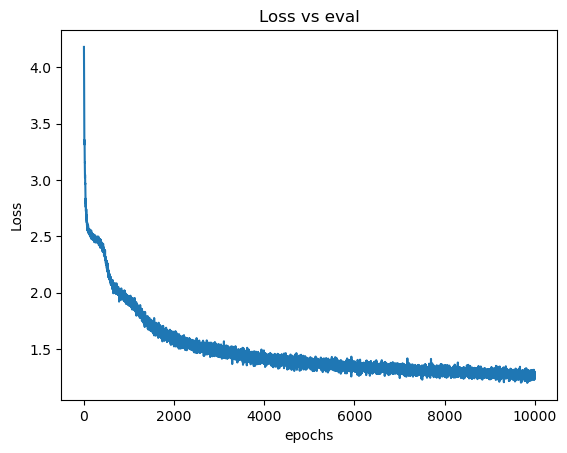

In [19]:
plt.plot([x for x in range(1,eval_iters+1)],losses)
plt.title("Loss vs eval")
plt.xlabel("epochs")
plt.ylabel("Loss")

In [28]:
print(decode(m.generate(torch.zeros((1,256),dtype=torch.long,device=device),1000)[0][256:].tolist()))

FTITTTURENEL:
TakLy, Enbui:'Rt!

HORTMARIANENA:
Wailing, at life, Even, mildly, that villain.

WESTMER:

CLIFFORD:
Ilind tear these would by preventies litty.

KING HENRY VI:

Against more worthy Sailloyars on him evil's eye,
For Will weekness strong-gentleman the danger
They son; if he must not in expedition Paris by oathanks,
Which, you say answer his greatness to traitor,
And yet me from me.
Join' God's sake.
And you that hanks, good so me? consured me madam?

BUCKINGHAM:
You welcome, wilt confessests to castle. 
I'll poisone worst shall desire movetous distance,
Is it meetime.

VOLUMNES:
What is that nyible Claudio, now their duchedness of the way?

AUTOLYCUS:
This cowards of Bohemely Fortunes welcome.

ANGELO:
Welcome, if I shall poison's medice?
Forse: I do it is onteous for every precious souls
Be that thy bustle, were be thou should the boar
Be this in our terruptings; the give we run,
Were you all, I hum judge; we are conver,
Ther hath doth not back of his well.,
may strikes I